In [18]:
from src.utils.other import SetTarget, CompleteGraph
import torch_geometric.transforms as T

from torch_geometric.datasets import QM9

sparse_dataset = QM9('./qm9', transform=SetTarget())
transform = T.Compose([CompleteGraph(), SetTarget()])
full_dataset = QM9('./qm9', transform=transform)


In [19]:
dataset = sparse_dataset[:1000]
full_dataset = full_dataset[:1000]

In [20]:
from scipy.sparse.linalg import eigsh
import torch
from torch_geometric.utils import to_dense_adj, get_laplacian
from torch_sparse import SparseTensor


def compute_first_eigenvalue(data_list):
    first_eigenvalues = []
    for data in data_list:
        edge_index = data.edge_index
        num_nodes = data.num_nodes
        #adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
        A = to_dense_adj(edge_index)[0]
        degrees = torch.sum(A, dim=1).unsqueeze(-1)
        I = torch.eye(num_nodes)
        D = torch.pow(degrees, -0.5).squeeze()
        D = torch.diag(D)
        lap_sym = I - torch.mm(torch.mm(D, A), D)

        eigenvalues = torch.sort(torch.real(torch.linalg.eigvals(lap_sym)))
        first_pos_eigenvalue = eigenvalues[0][1]
        first_eigenvalues.append(first_pos_eigenvalue)
    return first_eigenvalues

no_rewire = compute_first_eigenvalue(dataset)

In [21]:
from src.utils.rewire_utils import rewire_dataset_k0hop

new_dataset = rewire_dataset_k0hop(dataset, 3, 0.25)
k0_hop = compute_first_eigenvalue(new_dataset)

In [22]:
from src.utils.rewire_utils import  carbon_processing

new_dataset = carbon_processing(full_dataset, dataset, 'c2c',0.25)
c2c = compute_first_eigenvalue(new_dataset)

In [23]:
from src.utils.rewire_utils import  carbon_processing

new_dataset = carbon_processing(full_dataset, dataset, 'c2a',0.25)
c2a = compute_first_eigenvalue(new_dataset)

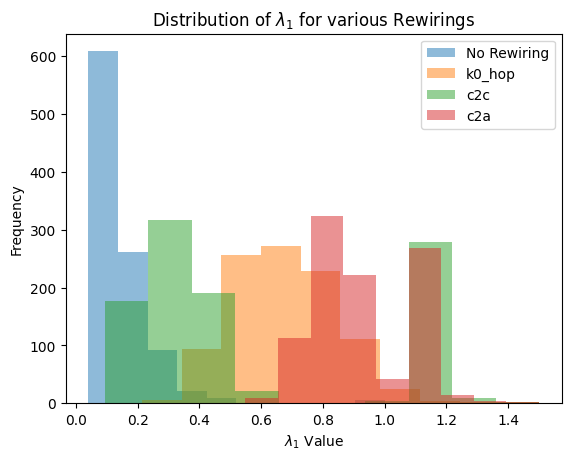

In [27]:
import matplotlib.pyplot as plt
import numpy as np


# Plot the histograms
plt.hist(np.array(no_rewire), alpha=0.5, label='No Rewiring')
plt.hist(np.array(k0_hop), alpha=0.5, label= 'k0_hop')
plt.hist(np.array(c2c), alpha=0.5, label='c2c')
plt.hist(np.array(c2a), alpha=0.5, label='c2a')


# Add axis labels and title
plt.xlabel('$\lambda_1$ Value')
plt.ylabel('Frequency')
plt.title('Distribution of $\lambda_1$ for various Rewirings')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [28]:
plt.savefig('lambda1_distr.png')

<Figure size 640x480 with 0 Axes>